In [1]:
import pandas as pd
import numpy as np
import datetime
import math
import os
import matplotlib.pyplot as plt
from pylab import rcParams

plt.style.use('ggplot')
%pylab inline --no-import-all

# 固定小数点5桁
"{0:.4f}".format(12.34)

#記号は基本　規定値かndarray 行数は8760で処理

#格納されている角度は、NDARRAYは、RAD

#有効数字2桁
%precision 2

#有効数字（有効桁数）: display.float_format
pd.options.display.float_format = '{:.2g}'.format

#太陽光発電初期値

#インプットデータ
input_data = pd.read_csv('hakata_ekimae_2017_data_from_meteoblue.csv') #データ1
        #the global horizontal radiation on the earth's surface averaged over the time step [MJ/m2]
#input_rad = pd.read_csv('rad.csv')#encordingはUTF-8なので注意 unitは、MJ/m2
input_csv_parameter = pd.read_csv('PV_input_parameter.csv')

#Rb用theta
#theta = pd.read_excel('theta.xls')

#1列目以外を抽出
input_csv_parameter = input_csv_parameter.iloc[:, [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]

Gsc = float(input_csv_parameter.iat[0,0])#float(1.367)#the solar constant [1.367 kW/m2]
Gt_NOCT = float(input_csv_parameter.iat[0,1]) #the solar radiation at which the NOCT is defined [0.8 kW/m2]
Ta_NOCT = float(input_csv_parameter.iat[0,2])#the ambient temperature at which the NOCT is defined [20°C]
Tc_NOCT = float(input_csv_parameter.iat[0,3]) #the nominal operating cell temperature [°C]
Tc_STC = float(input_csv_parameter.iat[0,4]) #the PV cell temperature under standard test conditions [25°C]

YPV = float(input_csv_parameter.iat[0,6]) #the rated capacity of the PV array, meaning its power output under standard test conditions [kW]
ap = float(input_csv_parameter.iat[0,7]) #Module Efficiency(Pmax)[%/℃]
beta= float(input_csv_parameter.iat[0,8])  #the slope of the surface [°]
eta_c = float(input_csv_parameter.iat[0,9]) #the solar absorptance and the solar transmittance[%]
fpv = float(input_csv_parameter.iat[0,10]) #the PV derating factor [%]
ganma = float(input_csv_parameter.iat[0,11]) #the azimuth of the surface [°]
lam=float(input_csv_parameter.iat[0,12])#the longitude [°]
phi=float(input_csv_parameter.iat[0,13])#the latitude [°]
rho_g = float(input_csv_parameter.iat[0,14]) # the ground reflectance, which is also called the albedo [%]
tau_a = float(input_csv_parameter.iat[0,15]) #the solar absorptance and the solar transmittance[%]
_Gt_STC =float(1) #the incident radiation at standard test conditions [1 kW/m2]
#UL = tau_a*Gt_NOCT/(Tc_NOCT-Ta_NOCT)
UL = float(input_csv_parameter.iat[0,5])
total_cost = float(input_csv_parameter.iat[0,16]) #total cost
Op_year = float(input_csv_parameter.iat[0,17]) #oparation year
cost = total_cost/(Op_year*365*24)#cost[yen/kW/h]
#列名の変更
input_data.columns = ['Year', 'Month', 'Day','Hour', 'Minute','Temperature(2m)', 'Mean Sea Level Pressure[hpa]', \
                          'Shortwave Radiation[W/m2]','Wind Speed(10m)[m/s]','Wind Direction(10m)' ,'Wind Speed(80m)[m/s]'\
                  , 'Wind Direction(80m)']


#日付型などの変更
input_data['Date'] = input_data[['Year', 'Month', 'Day']].apply(lambda x: '{}@{}@{}'.format(x[0], x[1], x[2]), axis=1)
Date = input_data['Date']
input_data['Date'] =pd.to_datetime(Date, format='%Y@%m@%d')

input_data['Time'] = input_data[['Year', 'Month', 'Day','Hour']].apply(lambda x: '{}@{}@{}@{}'.format(x[0], x[1], x[2],x[3]), axis=1)
Time = input_data['Time']
input_data['Time'] =pd.to_datetime(Time, format='%Y@%m@%d@%H')

### nの作成

def date0():
    n  = []  # 結果を入れるリストを用意
    day = 1
    j = 0
    for num in range(24):
        if j == 24:
            day +=1
            j=0
        else:
            j +=1
        n.append(day)  # 結果を追加
    return n  # 結果のリストを返す

def date1():
    n  = []  # 結果を入れるリストを用意
    day = 2
    j = 0
    for num in range(len(input_data)-24):
        if j == 24:
            day +=1
            j=1
        else:
            j +=1
        n.append(day)  # 結果を追加
    return n  # 結果のリストを返す

n0 = date0()
n1 = date1()
n0
n0.extend(n1)#リストn0にn1を合体

input_data['n']  = pd.Series(np.array(n0))

### nの作成完了

#theta 応急処置
#l_t=list(theta['cosθ'].values)
#l_tz=list(theta['cosθz'].values)       
#l = list([1])


#len(input_data['n'])
#input_data =pd.concat([input_data, theta], axis=1)
#input_data
#input_data['Rb'] = input_data['cos_t'] /input_data['cos_tz']

input_csv_parameter

Populating the interactive namespace from numpy and matplotlib


,Gsc,Gt_NOCT,Ta_NOCT,Tc_NOCT,Tc_STC,UL,YPV,ap,beta,eta_c,fpv,ganma,lam,phi,rho_g,tau_a,total_cost,Op_year
0,1.4,80,20,44,25,3,245,-0.0026,33,0.19,0.8,0,1.3e+02,33,0.2,0.9,199165,15


In [2]:
#ωの計算
input_data['ts'] = input_data['Hour']
input_data['ω'] = (input_data['ts'].values - 12 )*15#degree

#Bの計算
input_data['B'] = (360*((input_data['n'].values - 1) / 365))

#Eup
input_data['Eup'] = 3.82*(0.000075+0.001868*np.cos(input_data['B'].values)\
                             -0.032077*np.sin(input_data['B'].values))
#Ebottom
input_data['Ebottom'] = 3.82*(-0.014615*np.cos(2*input_data['B'].values)\
                             -0.04089*np.sin(2*input_data['B'].values))
#δの計算
input_data['δ the solar declination']=23.45*np.sin(np.deg2rad(360*(284+input_data['n'].values)/365))#degree

delta=input_data['δ the solar declination'].values#degree

#角度をdeg2rad
omega = np.deg2rad(input_data['ω'].values)#rad
delta =np.deg2rad(delta)#rad
phi =math.radians(phi)#rad
beta =math.radians(beta)#rad
ganma =math.radians(ganma)#rad
lam =math.radians(lam)#rad

#cosθの計算
input_data['cosθ'] = np.sin(delta)*math.sin(phi)*math.cos(beta)\
                    -np.sin(delta)*math.cos(phi)*math.sin(beta)*math.cos(ganma)\
                    +np.cos(delta)*math.cos(phi)*math.cos(beta)*np.cos(omega)\
                    +np.cos(delta)*math.sin(phi)*math.sin(beta)*math.cos(ganma)*np.cos(omega)\
                    +np.cos(delta)*math.sin(beta)*math.sin(ganma)*np.sin(omega)
                    
cos_theta = input_data['cosθ'].values
                
#θの計算
input_data['θ(radian)'] = np.arccos(input_data['cosθ'].values)#rad

input_data['θ(degree)'] = np.rad2deg(input_data['θ(radian)'].values)#degree

Theta_deg = input_data['θ(radian)'].values#rad

#cosθzの計算
input_data['cosθz'] =math.cos(phi)*np.cos(delta)*np.cos(omega)\
                        +math.sin(phi)*np.sin(delta)

cos_theta_z = input_data['cosθz'].values

input_data['θz(radian)'] = np.arccos(input_data['cosθz'].values)#rad

input_data['θz(degree)'] = np.rad2deg(input_data['θz(radian)'].values)#degree

Theta_z_deg = input_data['θz(radian)'].values#rad

#theta degree ndarray
theta = input_data['θ(radian)'].values#rad

#theta degree ndarray
theta_z = input_data['θz(radian)'].values#rad

#decimals=1で小数点第2位を四捨五入する
cos_theta = np.round(cos_theta, decimals=1)
cos_theta_z = np.round(cos_theta_z, decimals=1)
Theta_deg =np.round(Theta_deg, decimals=0)
Theta_deg_z = np.round(Theta_z_deg, decimals=0)

cos_theta = np.cos(Theta_deg)
cos_theta_z = np.cos(Theta_z_deg)

In [3]:
#Gon(the extraterrestrial normal radiation)[kW/m2]の計算
input_data['Gon(the extraterrestrial normal radiation)[kW/m2]'] \
=Gsc*(1+0.033*np.cos(np.deg2rad(360*input_data['n'].values/365)))#np.deg2rad

_Gon =input_data['Gon(the extraterrestrial normal radiation)[kW/m2]'].values

#Go(the extraterrestrial horizontal radiation [kW/m2])の計算
input_data['Go(the extraterrestrial horizontal radiation)[kW/m2]'] \
=_Gon*np.abs(cos_theta_z)

Go = input_data['Go(the extraterrestrial horizontal radiation)[kW/m2]'] .values

In [4]:
#_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]の計算

def step_minus(x):  #再帰関数　引数[2]-引数[1] ndarrayで返す ndarrayを引数
    x = list(x)
    y = [0]
    y.extend(x) #引数2
    x.extend([0]) #引数1
    y = np.array(y)
    x = np.array(x)
    ans = y - x
    return ans[1:]#[1:]or [:8760]


input_data['_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]'] \
=(12/np.pi)*_Gon*np.abs(np.cos(phi)*np.cos(delta)*step_minus(np.sin(omega))\
+((np.pi/180)*step_minus(omega)*np.sin(phi)*np.sin(delta)))

_Go = input_data['_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]'] 

#_G または　input_radの処理
    #欠損値を0で置き換える
#input_rad = input_rad.fillna(0)
#input_rad = input_rad.drop(8760)

    #input_radをMJ2kW
#input_data['the global horizontal radiation[kW/m2]']=\
#input_rad['the global horizontal radiation(MJ/㎡)'].values/3.6

input_data['the global horizontal radiation[kW/m2]']=\
input_data['Shortwave Radiation[W/m2]'].values/1000

_G = input_data['the global horizontal radiation[kW/m2]'].values
input_data['the global horizontal radiation[kW/m2]'] = _G 

In [5]:
#ktの計算
input_data['kt(the clearness index)'] =_G/_Go#_G2
kt = np.abs(input_data['kt(the clearness index)'].values)

#_Gdの計算
#２の３乗#累乗np.power(2, 3)
def if_kt(x):
    x = np.abs(x)
    ans = np.where(x>=0.8,0.165,np.where(x < 0.22, 1-0.09*x,0.95511-0.1604*x+4.388*x*x-16.638*x*x*x+12.336*x*x*x*x))
    return ans

input_data['_Gd(the diffuse radiation)[kW/m2]']=_G*if_kt(kt)
_Gd = input_data['_Gd(the diffuse radiation)[kW/m2]'].values

#_Gb(the beam radiation)の計算
input_data['_Gb(the beam radiation)[kW/m2]']=_G-_Gd

_Gb = input_data['_Gb(the beam radiation)[kW/m2]'].values

#_G
input_data['_G']=_Gd+_Gb

In [6]:
#Rbの計算
#input_data['Rb']= cos_theta/cos_theta_z
input_data['Rb']= input_data['cosθ'].values/input_data['cosθz'].values

#thetaの計算がjupyterだとうまくいかない泣
#input_data['Rb']=Rb
Rb = input_data['Rb'].values

#発散の処理 要考察 yを超えるとzになる　
def div(x,y,z):
    x = abs(x)
    ans = np.where(x>y,z,x)
    return ans
Rb = div(Rb,3,3)
input_data['Rb']= div(Rb,3,3)


#Afの計算
input_data['Af']=_Gb/_Go #_G2

Af = input_data['Af'].values

#fの計算
input_data['f']=np.sqrt(_Gb/_G) #_G2
    #欠損値を0で置き換える
input_data=input_data.fillna(0)
f = input_data['f'].values                         

In [7]:
def sin3(x):
    return math.sin(x)*math.sin(x)*math.sin(x)

#_Gtの計算#２の３乗#累乗np.power(2, 3) np.power(np.sin(beta/2),3) or def 3sin(x)
input_data['_Gt']=(_Gb+_Gd*Af)*Rb\
                +(_Gd*(1-Af)*((1+math.cos(beta))/2)\
                *np.abs(1+f*sin3(beta/2)))\
                +_G*rho_g*100*((1-math.cos(beta))/2)
_Gt= input_data['_Gt'].values  


In [8]:
#Tc(the PV cell temperature [°C])の計算
Ta = input_data['Temperature(2m)'].values
input_data['Tc(the PV cell temperature)[°C]']\
= Ta+_Gt*(tau_a/UL)*(1-eta_c/tau_a)

Tc = input_data['Tc(the PV cell temperature)[°C]'].values

#Ppv(the output of the PV array)[kW]の計算   #発散の処理div(x)を使用
input_data['Ppv(the output of the PV array)[Wh]']\
=div(YPV*fpv*(_Gt/_Gt_STC)*np.abs((1+ap*(Tc-Tc_STC))), YPV,YPV)

Ppv = input_data['Ppv(the output of the PV array)[Wh]'].values

input_data['Left'] = YPV*fpv*(_Gt/_Gt_STC)
input_data['Right'] =np.abs((1+ap*(Tc-Tc_STC)))

In [9]:
#入力初期値をデータフレームにする。
input_parameter_name=['Gsc','Gt_NOCT','Ta_NOCT','Tc_NOCT','Tc_STC','UL',\
                      'YPV','ap','beta','eta_c','fpv','ganma','lam','phi',\
                      'rho_g','tau_a','total_cost','Op_year','cost']

input_parameter_list=[Gsc,Gt_NOCT,Ta_NOCT,Tc_NOCT,Tc_STC,UL,\
                      YPV,ap,beta,eta_c,fpv,ganma,lam,phi,\
                      rho_g,tau_a,total_cost,Op_year,cost]

def float2DataFrame(name,list):
    df0=pd.DataFrame({str(name[0]): [list[0]]})
    for i in range(len(list)-1):
        a = float(list[i+1])
        df=pd.DataFrame({str(name[i+1]): [a]})
        df0 =pd.concat([df0, df], axis=1)
    return df0

input_parameter=float2DataFrame(input_parameter_name,input_parameter_list)
input_parameter

,Gsc,Gt_NOCT,Ta_NOCT,Tc_NOCT,Tc_STC,UL,YPV,ap,beta,eta_c,fpv,ganma,lam,phi,rho_g,tau_a,total_cost,Op_year,cost
0,1.4,80,20,44,25,3,2.4e+02,-0.0026,0.58,0.19,0.8,0,2.3,0.58,0.2,0.9,2e+05,15,1.5


In [10]:
#Timeをインデックスに設定ものをdfと定義
df = input_data.set_index("Time")
#データの書き出し
df.to_csv('PV_result.csv',encoding="shift_jis")   
input_parameter.to_csv('PV_input_parameter_result.csv',encoding="shift_jis")  

In [11]:
#df = input_data.set_index("Time")
df.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature(2m)',
       'Mean Sea Level Pressure[hpa]', 'Shortwave Radiation[W/m2]',
       'Wind Speed(10m)[m/s]', 'Wind Direction(10m)', 'Wind Speed(80m)[m/s]',
       'Wind Direction(80m)', 'Date', 'n', 'ts', 'ω', 'B', 'Eup', 'Ebottom',
       'δ the solar declination', 'cosθ', 'θ(radian)', 'θ(degree)', 'cosθz',
       'θz(radian)', 'θz(degree)',
       'Gon(the extraterrestrial normal radiation)[kW/m2]',
       'Go(the extraterrestrial horizontal radiation)[kW/m2]',
       '_Go(the extraterrestrial horizontal radiation averaged over the time step )[kW/m2]',
       'the global horizontal radiation[kW/m2]', 'kt(the clearness index)',
       '_Gd(the diffuse radiation)[kW/m2]', '_Gb(the beam radiation)[kW/m2]',
       '_G', 'Rb', 'Af', 'f', '_Gt', 'Tc(the PV cell temperature)[°C]',
       'Ppv(the output of the PV array)[Wh]', 'Left', 'Right'],
      dtype='object')

In [12]:
input_data['Rb'].describe()

count   8.8e+03
mean        1.3
std        0.68
min       0.011
25%        0.91
50%         1.1
75%         1.6
max           3
Name: Rb, dtype: float64

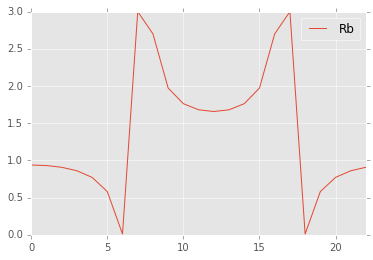

In [13]:
#抽出して範囲指定
df2=input_data[:23]
df3=input_data[2830:3150]

df2.plot(y='Rb')

In [14]:
df2['Rb'].describe()

count      23
mean      1.4
std      0.88
min     0.011
25%      0.82
50%      0.94
75%       1.9
max         3
Name: Rb, dtype: float64

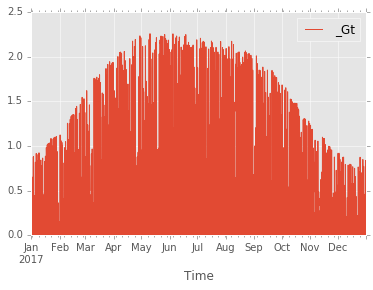

In [15]:
df.plot(y='_Gt')

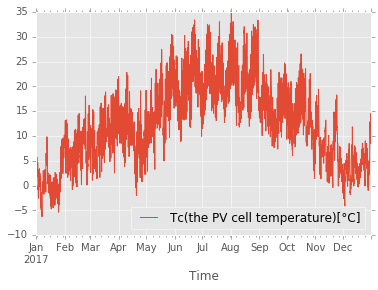

In [16]:
df.plot(y='Tc(the PV cell temperature)[°C]')

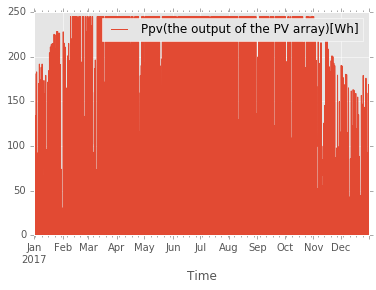

In [17]:
df.plot(y='Ppv(the output of the PV array)[Wh]')

/home/ec2-user/.pyenv/versions/anaconda3-4.0.0/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


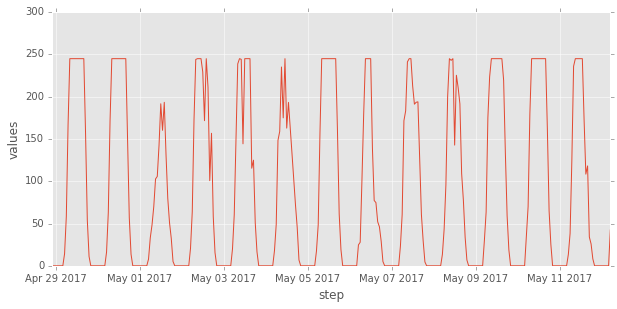

In [18]:
#df.plot(y='Ppv(the output of the PV array)[Wh]'figsize)

rcParams['figure.figsize'] = 10,10

input1 = df3['Time']
output1 = df3['Ppv(the output of the PV array)[Wh]']

fig = plt.figure(figsize=(30,20),dpi=400)

fig = plt.figure()
df3 = fig.add_subplot(2,1,1)

df3.plot(input1, output1)

df3.set_xlabel('step')
df3.set_ylabel('values')
#df3.set_xlim([0, 90000])
df3.set_ylim([0, 300])
df3.grid(True)

fig.show()

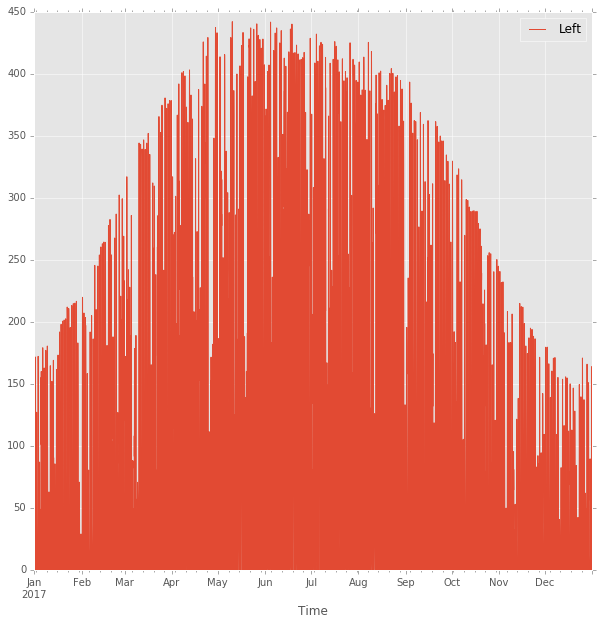

In [19]:
df.plot(y='Left')

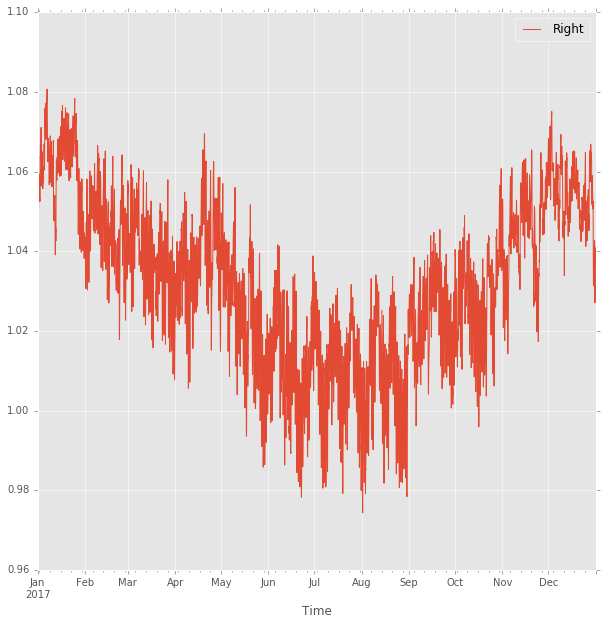

In [20]:
#df.plot(y='Ppv(the output of the PV array)[W]')
df.plot(y='Right')

In [21]:
#df.plot(y='Ppv(the output of the PV array)[W]')
#出力の標本統計を取る
Ppv = np.array(df['Ppv(the output of the PV array)[Wh]'])
pd.Series(Ppv).describe()

count   8.8e+03
mean         73
std          94
min           0
25%           0
50%           6
75%     1.5e+02
max     2.4e+02
dtype: float64

In [22]:
#列の順番変更
lst = df.columns.tolist()

lst.insert(0, 'Rb')
lst.insert(0, 'cosθz')
lst.insert(0, 'cosθ')

df[lst][:1000]

,cosθ,cosθz,Rb,Year,Month,Day,Hour,Minute,Temperature(2m),Mean Sea Level Pressure[hpa],...,_Gb(the beam radiation)[kW/m2],_G,Rb,Af,f,_Gt,Tc(the PV cell temperature)[°C],Ppv(the output of the PV array)[Wh],Left,Right
Time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,-0.92,-0.98,0.94,2017,1,1,0,0,3.4,1e+03,...,0,0,0.94,0,0,0,3.4,0,0,1.1
2017-01-01 01:00:00,-0.89,-0.96,0.93,2017,1,1,1,0,3.4,1e+03,...,0,0,0.93,0,0,0,3.4,0,0,1.1
2017-01-01 02:00:00,-0.8,-0.88,0.91,2017,1,1,2,0,3.5,1e+03,...,0,0,0.91,0,0,0,3.5,0,0,1.1
2017-01-01 03:00:00,-0.65,-0.76,0.86,2017,1,1,3,0,3,1e+03,...,0,0,0.86,0,0,0,3,0,0,1.1
2017-01-01 04:00:00,-0.46,-0.6,0.77,2017,1,1,4,0,2.5,1e+03,...,0,0,0.77,0,0,0,2.5,0,0,1.1
2017-01-01 05:00:00,-0.24,-0.41,0.58,2017,1,1,5,0,2.2,1e+03,...,0,0,0.58,0,0,0,2.2,0,0,1.1
2017-01-01 06:00:00,-0.0024,-0.21,0.011,2017,1,1,6,0,1.9,1e+03,...,0,0,0.011,0,0,0,1.9,0,0,1.1
2017-01-01 07:00:00,0.24,-0.016,3,2017,1,1,7,0,1.6,1e+03,...,0,0,3,0,0,0,1.6,0,0,1.1
2017-01-01 08:00:00,0.46,0.17,2.7,2017,1,1,8,0,1.8,1e+03,...,5.8e-05,0.02,2.7,8.8e-05,0.053,0.052,1.8,11,10,1.1
